# Подключение датасетов и API-ключей

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import openai
import requests
from google.colab import userdata

In [ ]:
from google.colab import userdata

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
DEEPSEEK_API_KEY = userdata.get('DEEPSEEK_API_KEY')

In [ ]:
# API-эндпойнт для DeepSeek
DEEPSEEK_BASE_URL = "https://api.deepseek.com"

In [ ]:
openai.api_key = OPENAI_API_KEY

In [ ]:
train_df = pd.read_csv('train.csv')
test_df  = pd.read_csv('test.csv')
val_df  = pd.read_csv('val.csv')

print("Train size:", len(train_df))
print("Test size:", len(test_df))
print("Validation size:", len(val_df))
print(train_df.head())

Train size: 172398
Test size: 48714
Validation size: 24628
   id                                               text  label
0   0  Отношения Гапона с эсерами также порвались в с...      0
1   1  В 1756 году его функции перешли к Конференции ...      0
2   2  Оценив имеющиеся варианты, в следующем году пр...      0
3   3  Тяжелая болезнь (с потерей глаза) вынудила Гуд...      0
4   4  Его сыновья также были приговорены к 51 и 68 г...      1


In [ ]:
print(val_df.head())

     id                                               text  label
0  9833  Это так удивительно, как много входит в один д...      0
1  9834  Впоследствии Муллинер, кажется, был капельмейс...      0
2  9835  От неё отказалась мать (отсюда — кличка, приду...      0
3  9836  Он остался во Франции после того, как его два ...      0
4  9837  Я помощник профессора в $3,000 и я чувствую се...      1


In [ ]:
print(test_df.head())

      id                                               text  label
0  11236         Модель 416 (заброшенная) калибр.41 Magnum.     -1
1  11237  С 1896 по 1897 год он безуспешно пытался верну...     -1
2  11238  Кампания общественного здравоохранения прошла ...     -1
3  11239  В Великом Лесиве.), главный персонаж борьбы с ...     -1
4  11240  Я компетентен, в здравом уме, и я пытаюсь сказ...     -1


In [ ]:
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())

label
0    86199
1    86199
Name: count, dtype: int64
label
0    12314
1    12314
Name: count, dtype: int64
label
-1    48714
Name: count, dtype: int64


# Методы

## TF-IDF + Logistic Regression

Здесь и далее в работе будет использоваться обучающая и валидационная выборки датасета CoAT. Тестовая выборка не включена в работу, поскольку её разметка скрыта и не может быть использована для локальной оценки качества моделей.

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    lowercase=True
)
X_train = vectorizer.fit_transform(train_df['text'])
X_val = vectorizer.transform(val_df['text'])

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, train_df['label'])

val_preds = clf.predict(X_val)
print("VAL Accuracy:", accuracy_score(val_df['label'], val_preds))
print("VAL F1:", f1_score(val_df['label'], val_preds))

VAL Accuracy: 0.7032239727139841
VAL F1: 0.6930410314560497


## RuBERT fine-tuning

In [ ]:
!pip install -q transformers datasets accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset
import evaluate

In [ ]:
#Подготовка данных
train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']])

In [ ]:
#Токенизация
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/172398 [00:00<?, ? examples/s]

Map:   0%|          | 0/24628 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"],
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="./rubert-ai-detection",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3558772472.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.315700,0.331354,0.851632,0.844418


TrainOutput(global_step=21550, training_loss=0.3804056922576267, metrics={'train_runtime': 4693.3127, 'train_samples_per_second': 36.733, 'train_steps_per_second': 4.592, 'total_flos': 1.133995493048832e+16, 'train_loss': 0.3804056922576267, 'epoch': 1.0})

## Zero-shot. GPT/DeepSeek

In [ ]:
from tqdm import tqdm
from openai import OpenAI

In [ ]:
client_gpt = OpenAI(api_key=OPENAI_API_KEY)
client_ds = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com")

In [ ]:
#GPT zero shot
def predict_gpt(text):
    prompt = f"Определи, пожалуйста, был ли этот текст сгенерирован искусственным интеллектом или написан человеком. Ответь 'AI' или 'Human'.\n\nТекст: {text}\nОтвет:"
    try:
        response = client_gpt.chat.completions.create(
            model="gpt-5",
            messages=[{"role": "user", "content": prompt}]
        )
        answer = response.choices[0].message.content.strip()
        return 1 if answer.lower() == "ai" else 0
    except Exception as e:
        print(f"GPT error: {e}")
        return None

In [ ]:
#DeepSeek zero shot
def predict_deepseek(text):
    headers = {"Authorization": f"Bearer {DEEPSEEK_API_KEY}"}
    payload = {"text": text}
    prompt = f"Определи, пожалуйста, был ли этот текст сгенерирован искусственным интеллектом или написан человеком. Ответь 'AI' или 'Human'.\n\nТекст: {text}\nОтвет:"
    try:
        response = client_ds.chat.completions.create(
            model="deepseek-chat",
            messages=[{"role": "user", "content": prompt}]
        )
        answer = response.choices[0].message.content.strip()
        return 1 if answer.lower() == "ai" else 0
    except Exception as e:
        print(f"DeepSeek error: {e}")
        return None

In [ ]:
#Устанавливаем количество текстов для теста
N_TEST = 100  # не ставлю больше, чтобы не сжечь токены
val_texts = val_df['text'][:N_TEST].tolist()
val_labels = val_df['label'][:N_TEST].tolist()

In [ ]:
#Генерация предсказаний с прогрессбаром
val_preds_gpt = [predict_gpt(t) for t in tqdm(val_texts)]
val_preds_ds = [predict_deepseek(t) for t in tqdm(val_texts)]

100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


In [ ]:
#Работа с метриками
acc_gpt = accuracy_score(val_labels, val_preds_gpt)
f1_gpt = f1_score(val_labels, val_preds_gpt)

acc_ds = accuracy_score(val_labels, val_preds_ds)
f1_ds = f1_score(val_labels, val_preds_ds)

print("\n--------- Zero-shot Evaluation (N=100) ---")
print(f"GPT zero-shot -> Accuracy: {acc_gpt:.3f}, F1: {f1_gpt:.3f}")
print(f"DeepSeek zero-shot -> Accuracy: {acc_ds:.3f}, F1: {f1_ds:.3f}")


--------- Zero-shot Evaluation (N=100) ---
GPT zero-shot -> Accuracy: 0.660, F1: 0.595
DeepSeek zero-shot -> Accuracy: 0.570, F1: 0.517


# Графическое представление результатов

In [ ]:
#Собираем данные в одном месте
import pandas as pd

results = pd.DataFrame({
    "Model": [
        "TF-IDF + LR",
        "RuBERT fine-tuned",
        "GPT zero-shot",
        "DeepSeek zero-shot"
    ],
    "Accuracy": [
        0.703,
        0.852,
        0.660,
        0.570
    ],
    "F1": [
        0.693,
        0.844,
        0.595,
        0.517
    ]
})

results

,Model,Accuracy,F1
0,TF-IDF + LR,0.703,0.693
1,RuBERT fine-tuned,0.852,0.844
2,GPT zero-shot,0.660,0.595
3,DeepSeek zero-shot,0.570,0.517


## Сравнение Accuracy для разных методов

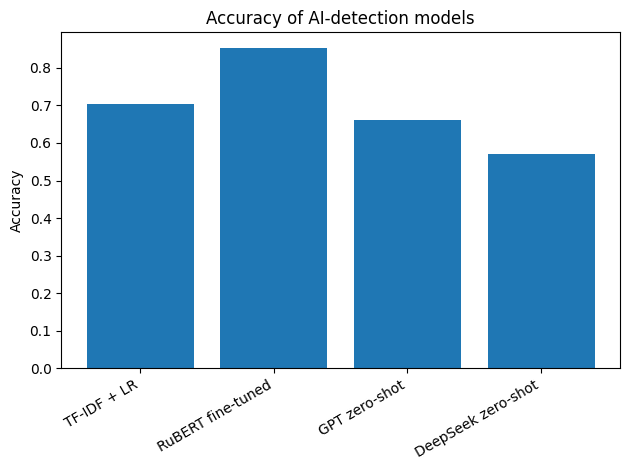

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(results["Model"], results["Accuracy"])
plt.title("Accuracy of AI-detection models")
plt.ylabel("Accuracy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

## Сравнение F1-score для разных методов

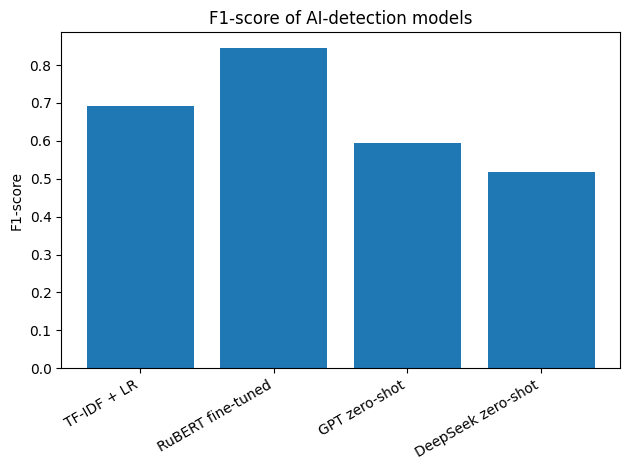

In [ ]:
plt.figure()
plt.bar(results["Model"], results["F1"])
plt.title("F1-score of AI-detection models")
plt.ylabel("F1-score")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

## Accuracy vs F1 (scatter plot)

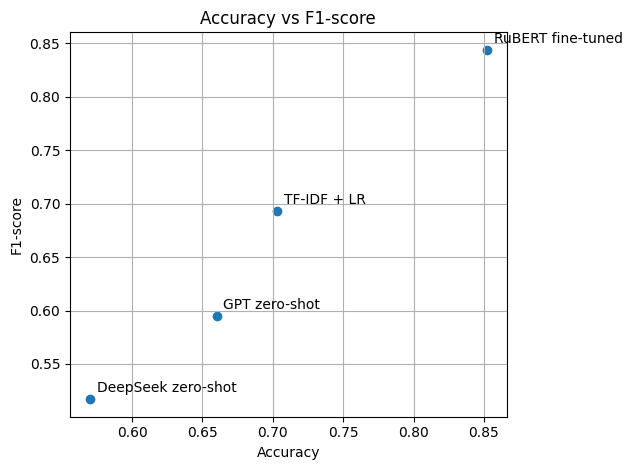

In [ ]:
plt.figure()
plt.scatter(results["Accuracy"], results["F1"])

for i, model in enumerate(results["Model"]):
    plt.annotate(
        model,
        (results["Accuracy"][i], results["F1"][i]),
        textcoords="offset points",
        xytext=(5,5)
    )

plt.xlabel("Accuracy")
plt.ylabel("F1-score")
plt.title("Accuracy vs F1-score")
plt.grid(True)
plt.tight_layout()
plt.show()